# Simulations for determining general variance of noise across various imaging cases

In [1]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers
import os
import logging, sys
import math

cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [10, 5]
plt.set_loglevel("critical")

wavelet_type_dict = {"daubechies" : 0, "iuwt" : 1}

wavelet_type = "daubechies"
wavelet_type_idx = wavelet_type_dict[wavelet_type]

## Load visibility layouts for long and short baseline databases, the same division is used for all three of our test cases so can use the same layout for all

In [2]:
from rascil.processing_components import create_visibility_from_ms

[vt] = create_visibility_from_ms('../data/SGRA.ms')

small_name = "SGRA_small_baselines_40"
long_name = "SGRA_long_baselines_30"
high = 40

[vs] = create_visibility_from_ms('../data4/' + small_name + '.ms')
[vl] = create_visibility_from_ms('../data4/' + long_name + '.ms')

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': '', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 249600 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 149271 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-0

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 120204 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)
/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapp

## Compute Noise for Long and Short baselines

### Read visibilities into long and short visibilities respectively

Model image plate scale (arcsec) is 3.814768e+00
Model image plate scale (arcsec) is 3.814768e+00


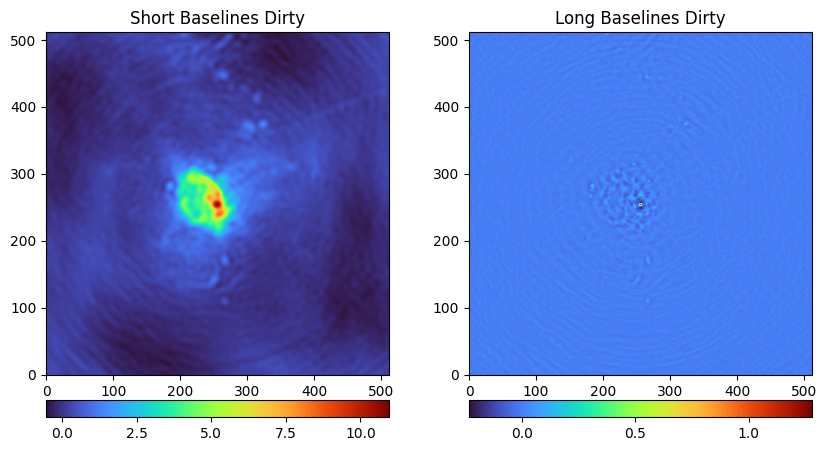

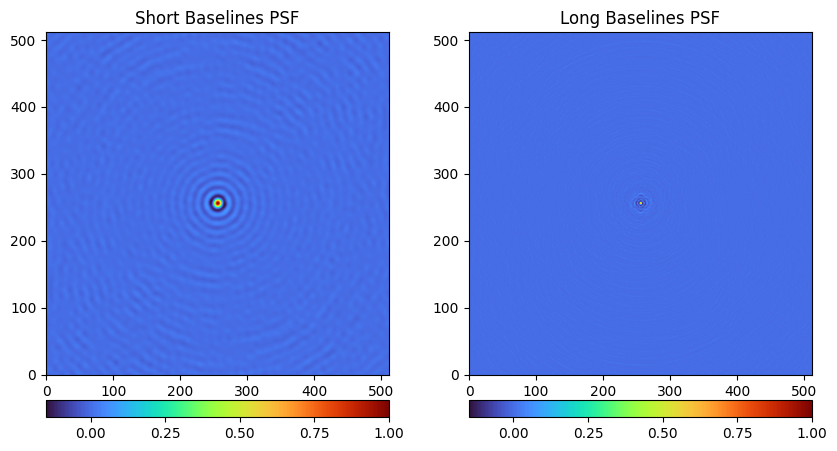

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


In [3]:
logging.getLogger().setLevel(logging.CRITICAL)

vt, full_cellsize, im = visibilities_from_image(vt,'../data/SGRA_full_gt.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())
dev = numpy.std(vt.vis.data.flatten())

vl, cell_size, im = visibilities_from_image(vl,'../data/SGRA_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)
vs, cell_size, im = visibilities_from_image(vs,'../data/SGRA_full_gt.fits',return_cellsize=True,return_image=True, \
                                            scale_factor=1.8, override_cellsize=True, ocellsize=full_cellsize)

dirty_l, psf_l = dirty_psf_from_visibilities(vl, full_cellsize, npix=512, weighting="uniform")
dirty_s, psf_s = dirty_psf_from_visibilities(vs, full_cellsize, npix=512, weighting="uniform")

helpers.plotNImages([dirty_s.pixels.data, dirty_l.pixels.data], ["Short Baselines Dirty", "Long Baselines Dirty"], cmap)
helpers.plotNImages([psf_s.pixels.data, psf_l.pixels.data], ["Short Baselines PSF", "Long Baselines PSF"], cmap)

logging.getLogger().setLevel(logging.NOTSET)

vis1 = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
img1, psf1 = dirty_psf_from_visibilities(vis1,cell_size,npix=512)

### Compute long baselines variance in image plane for some given amount of noise

### Same as above but for short baseline visibilities

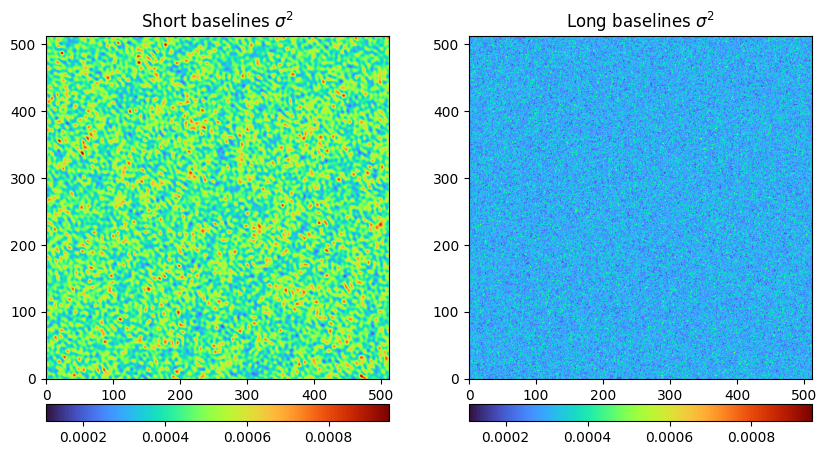

Mean variance for short baselines: 0.00045665087172226654
Mean variance for long baselines: 0.0003030448644953472


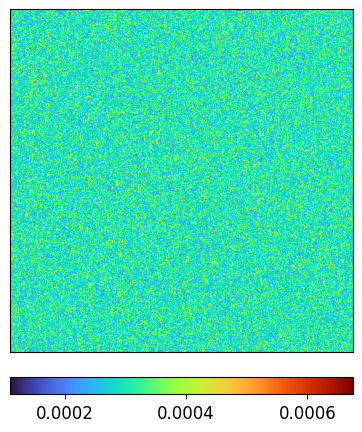

In [4]:
varimgs = helpers.readFits("../results/noise_results/" + small_name + "_variance_pixel.fits")
varimgl = helpers.readFits("../results/noise_results/" + long_name + "_variance_pixel.fits")

mean_var_s = numpy.mean(varimgs.flatten())
mean_var_l = numpy.mean(varimgl.flatten())

helpers.plotNImages([varimgs, varimgl], ["Short baselines $\sigma^2$", "Long baselines $\sigma^2$"], cmap, same_scale=True)
print("Mean variance for short baselines: " + str(mean_var_s))
print("Mean variance for long baselines: " + str(mean_var_l))
matplotlib.rcParams['figure.figsize'] = [5, 5]
helpers.plotNImages([varimgl], [""], cmap, output_file="../figures/vis_noise.png", hide_ticks=True,cbar_labelsize='large')

### Now compute variance on reconstructed short baselines

Mean reconstruction variance: 1.0051543384446855e-07


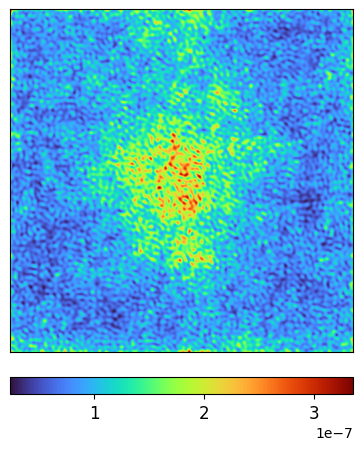

In [5]:
varimg = helpers.readFits("../results/noise_results/" + wavelet_type + "/" + small_name + "_reconstruction_variance_pixel.fits")
mean_var_r = numpy.mean(varimg.flatten())
helpers.plotNImages([varimg], [""], cmap, output_file="../figures/recon_noise.png", hide_ticks=True,cbar_labelsize='large')
print("Mean reconstruction variance: " + str(mean_var_r))

matplotlib.rcParams['figure.figsize'] = [10, 5]

# Estimation of noise Sgr A

### For visibility noise, can use the inter-pixel variance as a surrogate for the average per-pixel variance

In [6]:
est_vis = helpers.addNoiseToVis(vl, 2, real_deviation=stdv_real, imag_deviation=stdv_imag)
est_img, est_psf = dirty_psf_from_visibilities(est_vis,cell_size,npix=512)
print(numpy.var(est_img.pixels.data))

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00
0.0004294764112869585


### Estimating reconstruction noise is leftfor now, computing it using the visibility noise seems to be a heuristic that works decently well

# Results for all partitions

### Visibility noise with estimates

In [7]:
%%capture
logging.getLogger().setLevel(logging.CRITICAL)

long_names = ["SGRA_long_baselines_15", "SGRA_long_baselines_30", "SGRA_long_baselines_50", \
          "SGRB_long_baselines_15", "SGRB_long_baselines_30", "SGRB_long_baselines_50", \
          "SGRC_long_baselines_15", "SGRC_long_baselines_30", "SGRC_long_baselines_50"]

short_names = ["SGRA_small_baselines_25", "SGRA_small_baselines_40", "SGRA_small_baselines_60", \
          "SGRB_small_baselines_25", "SGRB_small_baselines_40", "SGRB_small_baselines_60", \
          "SGRC_small_baselines_25", "SGRC_small_baselines_40", "SGRC_small_baselines_60"]

long_sizes = [25, 25, 25, 40, 40, 40, 60, 60, 60]

measured_vis = ["measured $\sigma^2$"]
estimated_vis = ["estimated $\sigma^2$"]
measured_recon = ["measured $\eta^2$"]
estimated_recon = ["estimated $\eta^2$"]

def compute_windowed_var(image, window):
    estimated_variance = numpy.zeros(image.shape)

    #convolving initial signal with a variance estimation kernel with a size 2xwindow_hsize+1
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            start_x = max(x - window, 0)
            end_x = min(x + window + 1, image.shape[0])
            start_y = max(y - window, 0)
            end_y = min(y + window + 1, image.shape[1])

            estimated_variance[x, y] = numpy.var(image[start_x:end_x, start_y:end_y])
            
    return estimated_variance
    
for i, long_name in enumerate(long_names):
    img_measured = helpers.readFits("../results/noise_results/" + long_name + "_variance_pixel.fits")
    measured_vis.append(numpy.mean(img_measured.flatten()))
    
    [vl] = create_visibility_from_ms('../data4/' + long_name + '.ms')
    dirty, psf = dirty_psf_from_visibilities(vl,cell_size,npix=512)
    windowed_var = compute_windowed_var(dirty.pixels.data[0,0,:,:], 2)
    
    ev = numpy.mean(windowed_var.flatten())
    estimated_vis.append(ev)
    
    #factor = long_sizes[i] / (60*60*1000)
    factor = 1 / 1000
    estimated_recon.append(ev * factor)
    
for short_name in short_names:
    varimg = helpers.readFits("../results/noise_results/" + wavelet_type + "/" + \
                              short_name + "_reconstruction_variance_pixel.fits")
    measured_recon.append(numpy.mean(varimg.flatten()))
    
    [vs] = create_visibility_from_ms('../data4/' + short_name + '.ms')
    dirty, psf = dirty_psf_from_visibilities(vs,cell_size,npix=512)
    windowed_var = compute_windowed_var(dirty.pixels.data[0,0,:,:], 2)
    #ev = numpy.mean(windowed_var.flatten())
    
    #estimated_recon.append(ev)
    
logging.getLogger().setLevel(logging.NOTSET)

In [8]:
import pandas as pd

data = [measured_vis, estimated_vis, measured_recon, estimated_recon]
pd.DataFrame(data, columns=["Configuration", "Sgr A $\delta=20$", "Sgr A $\delta=35$", "Sgr A $\delta=55$", \
         "Sgr B $\delta=20$", "Sgr B $\delta=35$", "Sgr B $\delta=55$", \
         "Sgr C $\delta=20$", "Sgr C $\delta=35$", "Sgr C $\delta=55$"])

,Configuration,Sgr A $\delta=20$,Sgr A $\delta=35$,Sgr A $\delta=55$,Sgr B $\delta=20$,Sgr B $\delta=35$,Sgr B $\delta=55$,Sgr C $\delta=20$,Sgr C $\delta=35$,Sgr C $\delta=55$
0,measured $\sigma^2$,2.807223e-04,3.030449e-04,3.549740e-04,1.996538e-05,2.156026e-05,2.533529e-05,3.945995e-06,4.262045e-06,5.005369e-06
1,estimated $\sigma^2$,2.227586e-04,2.265075e-04,2.456868e-04,9.106268e-05,5.965832e-05,3.757927e-05,2.798107e-06,2.710931e-06,2.799886e-06
2,measured $\eta^2$,1.955704e-08,1.005154e-07,2.572078e-07,1.551582e-09,9.516400e-09,2.013421e-08,3.021132e-10,1.557855e-09,3.244249e-09
3,estimated $\eta^2$,2.227586e-07,2.265075e-07,2.456868e-07,9.106268e-08,5.965832e-08,3.757927e-08,2.798107e-09,2.710931e-09,2.799886e-09
